<a href="https://colab.research.google.com/github/TWAAXOne/Network-intrusion-detection-with-machine-learning/blob/main/CNN_Mutliclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mise en place du modèle permettant de prédire la catégorie d'une attaque réseau
Grace à ce modèle, nous allons pouvoir prédire la catégorie d'une attaque réseau en fonction de ses caractéristiques.
Nous allons utilisé le fichier csv précédemment créé dans le script "prepare_data_CNN". Les données sont déjà préparées pour être utilisées dans un modèle de réseau de neurones.

## Importation des librairies

In [1]:
# Forcer l'utilisation de Tensorflow 2.x
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
# Install les packages nécessaires
!pip install bayesian-optimization
!pip install mlxtend --upgrade --no-deps

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras import Model
from keras.layers import Input
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
import time
# Ordinateur Local
# from keras.src.layers import BatchNormalization, ReLU, Conv2D, Flatten, Dense, concatenate, MaxPooling2D, Dropout

# Google Colab
from google.colab import drive
from tensorflow.keras.layers import BatchNormalization, ReLU, Conv2D, Flatten, Dense, concatenate, MaxPooling2D, Dropout


## Importation des données

In [4]:
# Import des données Local
# data = pd.read_csv('all_data_UNSW-NB15.csv', low_memory=False)

In [5]:
# Import des données sur Google Colab
# Récupérer son drive Google
drive.mount('/content/drive')
# Path
path_data = "/content/drive/MyDrive/Data/all_data_UNSW-NB15.csv"

# Import des données
data = pd.read_csv(path_data,dtype='float')

Mounted at /content/drive


## Affichage des données

In [6]:
data.head()

,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,...,attack_cat_analysis,attack_cat_backdoor,attack_cat_dos,attack_cat_exploits,attack_cat_fuzzers,attack_cat_generic,attack_cat_normal,attack_cat_reconnaissance,attack_cat_shellcode,attack_cat_worms
0,119.0,6.0,0.0,0.0,0.0,254.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,113.0,5.0,1.0,0.0,0.0,62.0,252.0,0.0,0.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,113.0,5.0,10.0,0.0,0.0,254.0,252.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,113.0,5.0,0.0,0.0,0.0,254.0,252.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,113.0,5.0,0.0,0.0,0.0,254.0,252.0,0.0,0.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Récupération de la valeur de la variable cible

In [7]:
# Définition de 'y' en fonction des colonnes d'encodage one-hot
y_cols = ['attack_cat_analysis', 'attack_cat_backdoor', 'attack_cat_dos', 'attack_cat_exploits', 'attack_cat_fuzzers',
          'attack_cat_generic', 'attack_cat_normal', 'attack_cat_reconnaissance', 'attack_cat_shellcode',
          'attack_cat_worms']

y = data[y_cols]

# Extraction des colonnes "attack_cat" pour les stocker dans 'y'
# y = data[y_cols]
# Conversion de 'y' en tableau numpy
#y_values = y.values
# Récupération des noms des colonnes
#y_columns = y.columns

# Suppression des colonnes d'encodage one-hot après avoir défini 'y'
data.drop(y_cols, axis=1, inplace=True)

In [8]:
# suppression de la colonne 'label'
data.drop('label', axis=1, inplace=True)

## Affichage des données en images

In [9]:
# La longueur de notre dataset est de 42 colonnes et de 257673 lignes
print(data.shape)

(464937, 43)


In [10]:
# Chaque ligne aura une longueur de 64 valeurs
# Actuellement, chaque ligne est composée de 43 valeurs donc nous ajoutons 21 valeurs pour arriver à 64
# (0,0) : 0 ligne ajoutée en haut, 0 ligne ajoutée en bas
# (0,22) : 0 colonne ajoutée à gauche, 22 colonnes ajoutées à droite
# 'constant' : Les valeurs ajoutées sont des 0
byte_images = np.pad(data.to_numpy(), ((0, 0), (0, 21)), 'constant')
print(byte_images.shape)

(464937, 64)


Image normale :
Normal Output


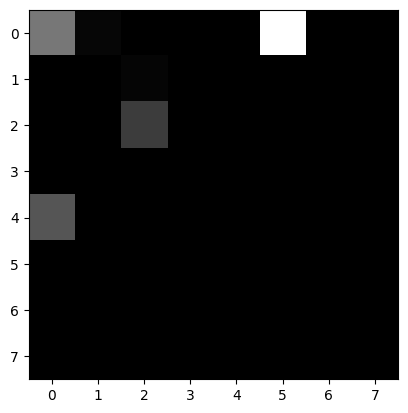

Generic Output


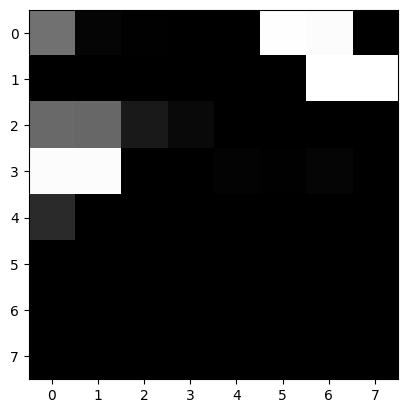

Exploits Output


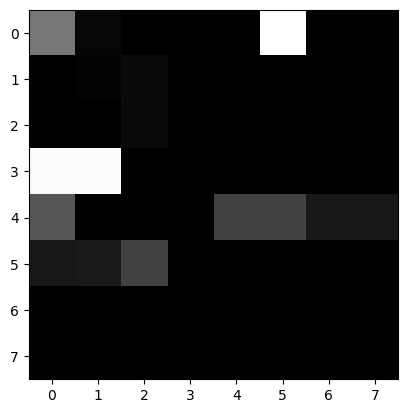

Fuzzers Output


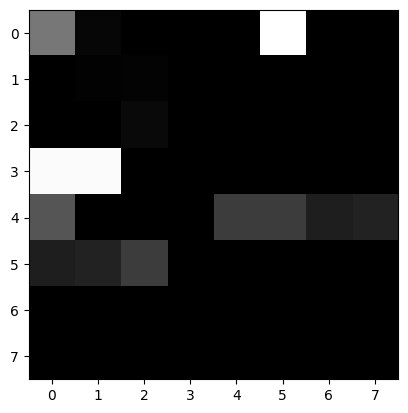

DoS Output


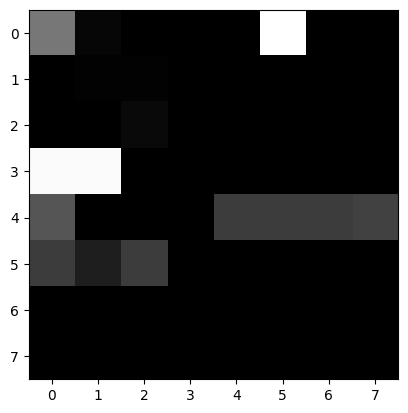

Reconnaissance Output


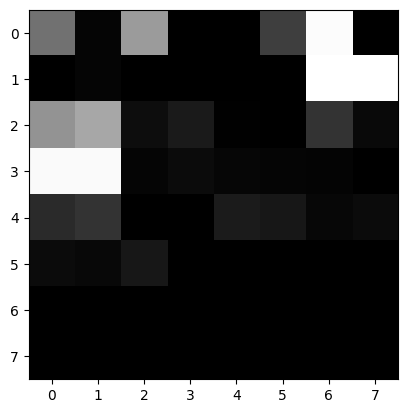

Analysis Output


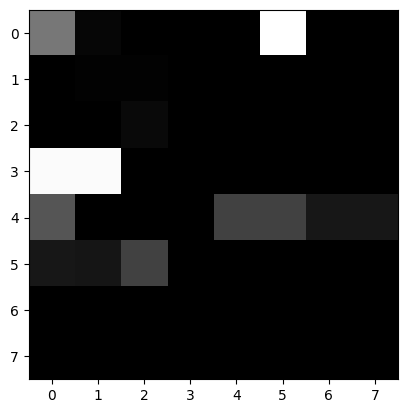

Backdoor Output


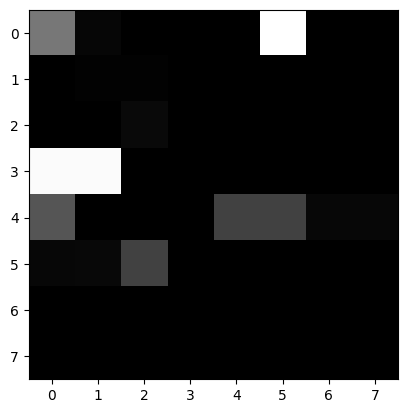

Shellcode Output


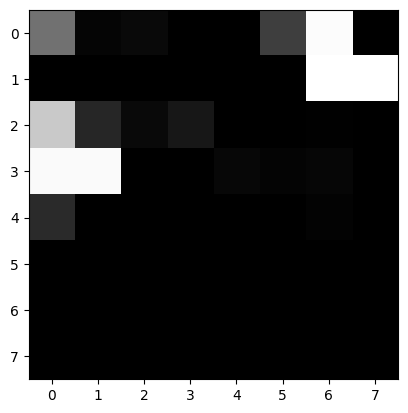

Worms Output


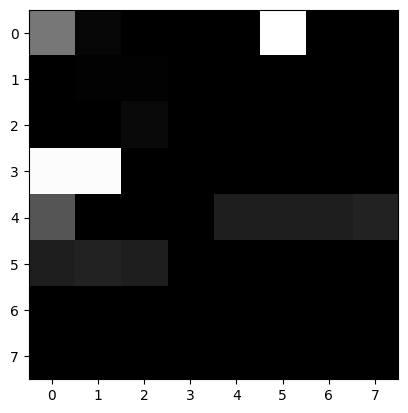

In [11]:
# Plot d'une image
def plot_single_image(byte_image):
    grayImage = byte_image.reshape(8, 8)  # On redimensionne l'image
    plt.imshow(grayImage, cmap="gray")  # On affiche l'image avec une colormap en niveau de gris
    plt.show()  # On affiche l'image


print("Image normale :")
print("Normal Output")
plot_single_image(byte_images[0])  # index 0 = Normal
print("Generic Output")
plot_single_image(byte_images[117204])
print("Exploits Output")
plot_single_image(byte_images[48932])
print("Fuzzers Output")
plot_single_image(byte_images[48017])
print("DoS Output")
plot_single_image(byte_images[48999])
print("Reconnaissance Output")
plot_single_image(byte_images[48866])
print("Analysis Output")
plot_single_image(byte_images[47932])
print("Backdoor Output")
plot_single_image(byte_images[47911])
print("Shellcode Output")
plot_single_image(byte_images[48813])
print("Worms Output")
plot_single_image(byte_images[49959])

In [12]:
# Normaliser les données de -0.5 à 0.5
# Après plusieurs test, l'entrainement ce fait plus rapidement après la normalisation
# Car l'algorithme de descente de gradient converge plus rapidement
# x = []
# for image in np.array(byte_images):
#     x.append((image / 255 - 0.5)) # Normalisation des valeurs entre -0.5 et 0.5

# Transformation de x en matrice
# x = np.array(x)
# x.shape = (930'000, 64)
# x = x.reshape(x.shape[0], 8, 8, 1)
# Transforme le vecteur x en une matrice 4D de taille (930'000, 8, 8, 1)
# chaque element de la liste x est un vecteur de taille 64, nous la transformons en un carré donc 8x8.
# 1 car nous avons une seule couleur (niveau de gris)


In [13]:
# Récupération des valeurs de 'byte_images' dans 'x'
x = np.array(byte_images)
x.shape

(464937, 64)

In [14]:
x = x.reshape(data.shape[0], 8, 8, 1)
# Transforme le vecteur x en une matrice 4D de taille (2'540'047, 8, 8, 1)
# chaque element de la liste x est un vecteur de taille 64, nous la transformons en un carré donc 8x8x1.
# 1 car nous avons une seule couleur (niveau de gris)

In [15]:
def plot_accuracies(nets, history, names, y_accuracy):
    """
    Affiche un graphique des précisions de validation pour différents modèles
    sur plusieurs époques d'entraînement.

    :param nets: Nombre total de modèles à afficher.
    :param history: Liste contenant l'historique d'entraînement pour chaque modèle.
    :param names: Liste des noms des modèles.
    :param y_accuracy: Limites pour l'axe des ordonnées (précision).
    """
    # Initialisation de la figure
    plt.figure(figsize=(15, 5))
    # Liste de couleurs pour les différentes courbes
    color = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    # Boucle pour tracer la précision de validation pour chaque modèle
    for i in range(nets):
        plt.plot(history[i].history['val_accuracy'], linestyle='--', color=color[i])
    # Titre et étiquettes pour les axes
    plt.title('Précision du modèle')
    plt.ylabel('Précision')
    plt.xlabel('Époque')
    # Légende du graphique
    plt.legend(names, loc='upper left')
    # Configuration de l'axe des ordonnées et activation de la grille
    axes = plt.gca()
    axes.set_ylim(y_accuracy)
    plt.grid(True)
    # Affichage du graphique
    plt.show()


### Séparation des données en train et test (Stratifié pour dataset déséquilibré)
Utilisation de la validation stratifiée pour séparer les données en train et test. Car nous avons un dataset déséquilibré.
Malheureusement, nous n'allons pas pouvoir utiliser la validation croisée car cela prendrait trop de temps et de ressources.

In [16]:
# Séparation des données en données d'entraînement et données de test
# StratifiedShuffleSplit permet de conserver la même proportion de classes dans les données d'entraînement et de test
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_index, test_index in sss.split(x, y):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Création du modèle
## Quel est la structure du modèle idéal ?

In [17]:
nb_classes = y.shape[1]  # Nombre de classes
print(nb_classes)

10


In [18]:
nets = 5  # Nombre de modèle
model = [0] * nets  # Liste des modèles
history = [0] * nets  # Liste des historiques d'entraînement pour chaque modèle
names = ["ClassicConvNet", "NormedConvNet", "MiniVGGNet", "GoogleNet", "DenseNet"]  # Noms des modèles

epochs = 20  # Nombre d'époques d'entraînement
batch_size = 128  # Taille du lot

results = []  # Afin d'afficher les résultats de chaque modèle

# Boucle pour créer les modèles
for net in range(nets):
    input_img = Input(shape=(8, 8, 1))  # Définition de la taille des images en entrée
    if net == 0:  # ClassicConvNet
        # Bloc 1
        block_1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
        block_1 = Conv2D(64, (3, 3), activation='relu', padding='same')(block_1)
        block_1 = MaxPooling2D(pool_size=(2, 2))(block_1)  # Corrigé ici
        block_1 = Conv2D(128, (3, 3), activation='relu', padding='same')(block_1)
        block_1 = Conv2D(128, (3, 3), activation='relu', padding='same')(block_1)
        block_1 = Conv2D(128, (3, 3), activation='relu', padding='same')(block_1)
        block_1 = MaxPooling2D(pool_size=(2, 2))(block_1)  # Corrigé ici
        block_1 = Conv2D(256, (3, 3), activation='relu', padding='same')(block_1)
        block_1 = Conv2D(256, (3, 3), activation='relu', padding='same')(block_1)
        block_1 = Conv2D(256, (3, 3), activation='relu', padding='same')(block_1)
        block_1 = MaxPooling2D(pool_size=(2, 2))(block_1)  # Corrigé ici
        output = Flatten()(block_1)
        # Bloc 2
        output = Dense(100, kernel_initializer='normal', activation='relu')(output)
        output = Dropout(0.5)(output)
        output = Dense(20, kernel_initializer='normal', activation='relu')(output)
        out = Dense(nb_classes, kernel_initializer='normal', activation='softmax')(output)
    elif net == 1:  # NormedConvNet
        block_1 = BatchNormalization()(input_img)
        block_1 = ReLU()(block_1)
        block_1 = Conv2D(32, (3, 3), padding='same')(block_1)
        block_1 = BatchNormalization()(block_1)
        block_1 = ReLU()(block_1)
        block_1 = Conv2D(32, (3, 3), padding='same')(block_1)
        output = Flatten()(block_1)
        output = Dense(128, activation='relu')(output)
        out = Dense(nb_classes, activation='softmax')(output)
    elif net == 2:  # MiniVGGNet
        block_1 = Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(8, 8, 1))(input_img)
        block_1 = BatchNormalization()(block_1)
        block_1 = Conv2D(32, (3, 3), padding="same", activation="relu")(block_1)
        block_1 = BatchNormalization()(block_1)
        block_1 = MaxPooling2D(pool_size=(2, 2))(block_1)
        block_1 = Dropout(0.25)(block_1)
        output = Flatten()(block_1)
        output = Dense(512, activation="relu")(output)
        output = BatchNormalization()(output)
        output = Dropout(0.5)(output)
        out = Dense(nb_classes, activation="softmax")(output)
    elif net == 3:  # GoogleNet (Inception simplifié)
        tower_1 = Conv2D(64, (1, 1), padding='same', activation='relu')(input_img)
        tower_1 = Conv2D(64, (3, 3), padding='same', activation='relu')(tower_1)
        tower_2 = Conv2D(64, (1, 1), padding='same', activation='relu')(input_img)
        tower_2 = Conv2D(64, (5, 5), padding='same', activation='relu')(tower_2)
        tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input_img)
        tower_3 = Conv2D(64, (1, 1), padding='same', activation='relu')(tower_3)
        output = concatenate([tower_1, tower_2, tower_3], axis=1)
        output = Flatten()(output)
        out = Dense(nb_classes, activation='softmax')(output)
    elif net == 4:  # DenseNet simplifié
        # première couche de convolution
        x = Conv2D(32, (3, 3), padding='same', activation='relu')(input_img)
        x = BatchNormalization()(x)
        concat1 = concatenate([input_img, x])
        # deuxième couche de convolution
        x1 = Conv2D(32, (3, 3), padding='same', activation='relu')(concat1)
        x1 = BatchNormalization()(x1)
        concat2 = concatenate([input_img, x, x1])
        # troisième couche de convolution
        x2 = Conv2D(32, (3, 3), padding='same', activation='relu')(concat2)
        x2 = BatchNormalization()(x2)
        concat3 = concatenate([input_img, x, x1, x2])
        output = Flatten()(concat3)
        out = Dense(nb_classes, activation='softmax')(output)

    # Début du chronomètre
    start_time = time.time()  # Début du chronomètre

    # Création du modèle
    model[net] = Model(inputs=input_img, outputs=out)
    model[net].summary()
    model[net].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    history[net] = model[net].fit(x_train, y_train, validation_data=(x_test, y_test), verbose=1, batch_size=batch_size,
                                  epochs=epochs)
    score = model[net].evaluate(x_test, y_test, verbose=0)

    # Fin du chronomètre
    end_time = time.time()  # Fin du chronomètre
    training_time = end_time - start_time
    model_params = model[net].count_params()

    # Stockage des résultats pour chaque modèle
    results.append({
        'Nom': names[net],
        'Accuracy': score[1],
        'Loss': score[0],
        'Nombre de paramètres': model_params,
        'Temps d\'entraînement': training_time
    })

    print("\nCNN: {}, Epochs={}, Batch_size={}, Test loss={}, Test accuracy={}\n".format(names[net], epochs, batch_size,
                                                                                         score[0], score[1]))

# Conversion de la liste en DataFrame
df_results = pd.DataFrame(results)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8, 8, 1)]         0         
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 64)          640       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 64)         0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 128)         147584    
                                                             

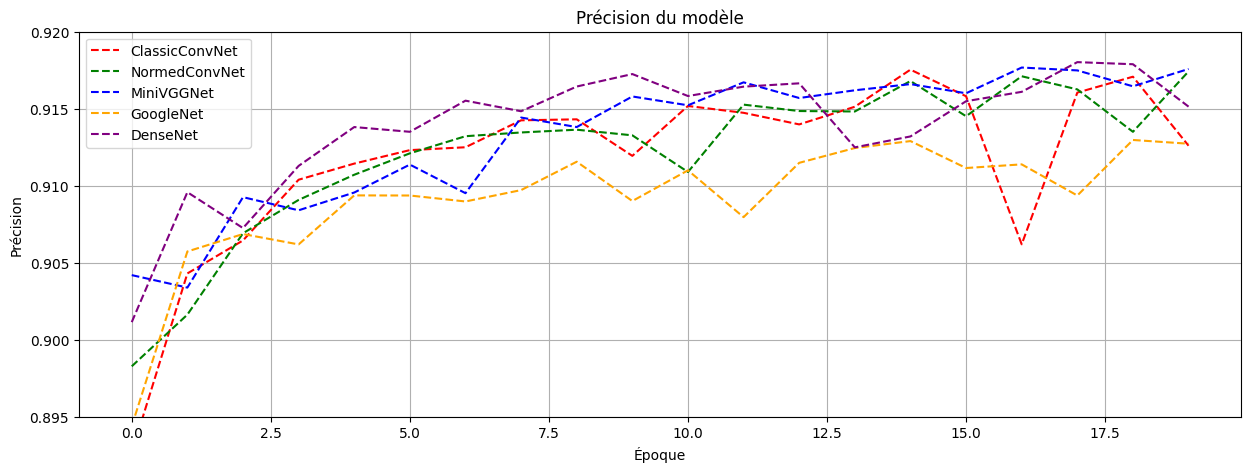

              Nom  Accuracy      Loss  Nombre de paramètres  \
2      MiniVGGNet  0.917581  0.220384                279658   
1   NormedConvNet  0.917423  0.220348                273262   
4        DenseNet  0.915136  0.224534                 89866   
3       GoogleNet  0.912727  0.236337                262666   
0  ClassicConvNet  0.912598  0.244092               1909850   

   Temps d'entraînement  
2            330.273370  
1            273.600129  
4            332.620698  
3            303.753729  
0            455.696575  


In [21]:
plot_accuracies(nets,history,names,[0.895,0.92])
df_sorted = df_results.sort_values(by="Accuracy", ascending=False)
print(df_sorted)


Nous réussissons à obtenir des scores d'accuracy très élevés avec les différents modèles. Cependant, nous avons un dataset déséquilibré. Nous allons donc afficher les matrices de confusion pour chaque modèle afin de voir si les modèles arrivent à prédire les différentes classes.

Mais, ce graphique nous montre que les modèles "NormedConvNet", "MiniVGGNet" et "MiniVGGNet" arrivent sont plus éfficaces que le modèle "GoogleNet" et "ClassicConvNet". Classiconvnet est très variable pendant l'entrainement.

- MiniVGGNet: Très bonne accuracy et loss, nombre relativement faible de paramètres et temps d'entraînement rapide.
- NormedConvNet: Très bonne accuracy et loss, nombre relativement faible de paramètres et temps d'entraînement rapide.
- DenseNet: Très bonne accuracy et loss (reste moins bon que les deux premiers), mais à un nombre de parametre le plus faible. Ce qui explique qu'il est le moins complexe. De plus, il a un très bon accuracy et loss.
- GoogleNet: Bonne accuracy et loss, mais reste moins bon que les trois premiers.
- ClassicConvNet: Bonne accuracy et loss, mais reste moins bon que les trois premiers. Beaucoup trop de paramètres et temps d'entraînement très long.

4359/4359 [==============================] - 9s 2ms/step


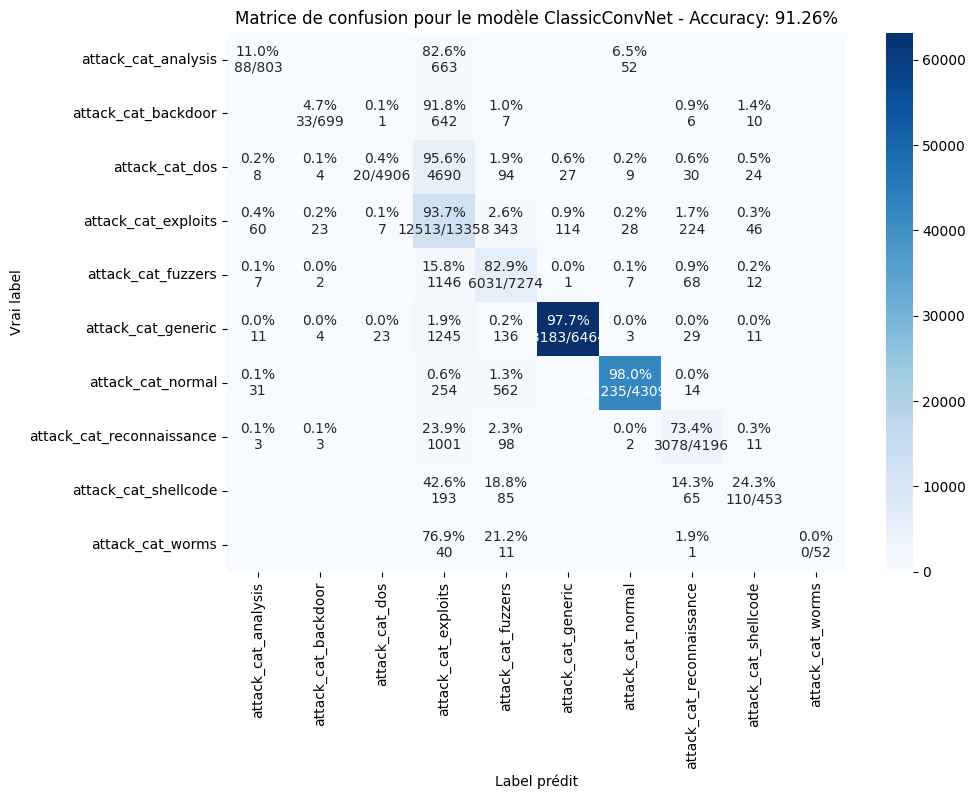

4359/4359 [==============================] - 7s 2ms/step


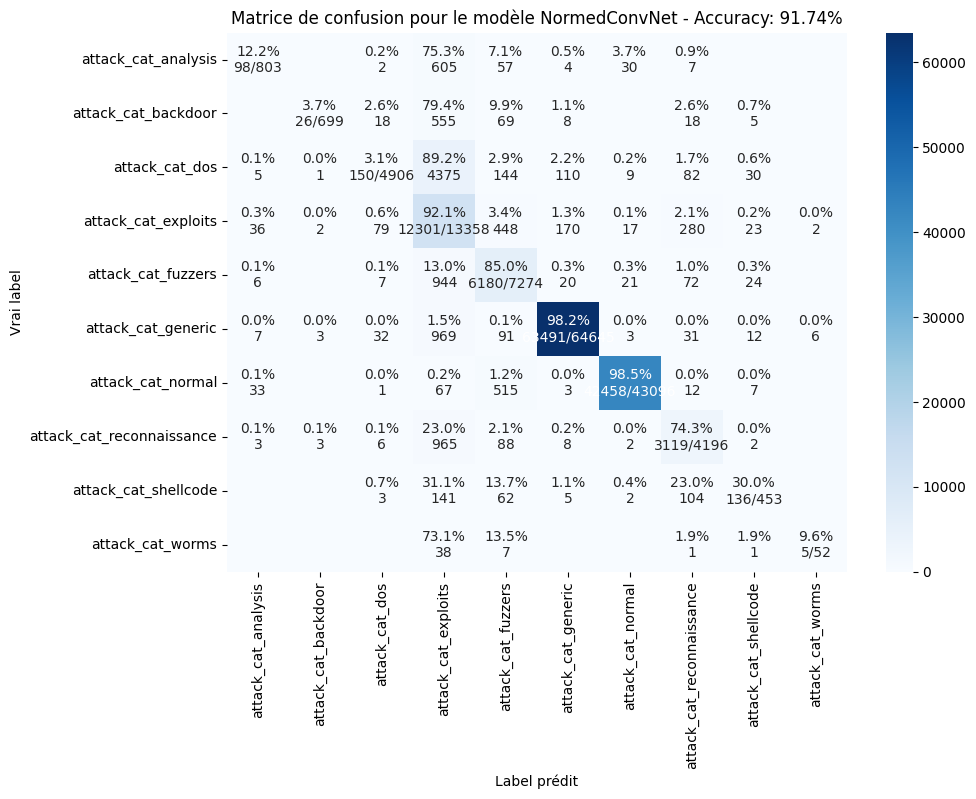

4359/4359 [==============================] - 8s 2ms/step


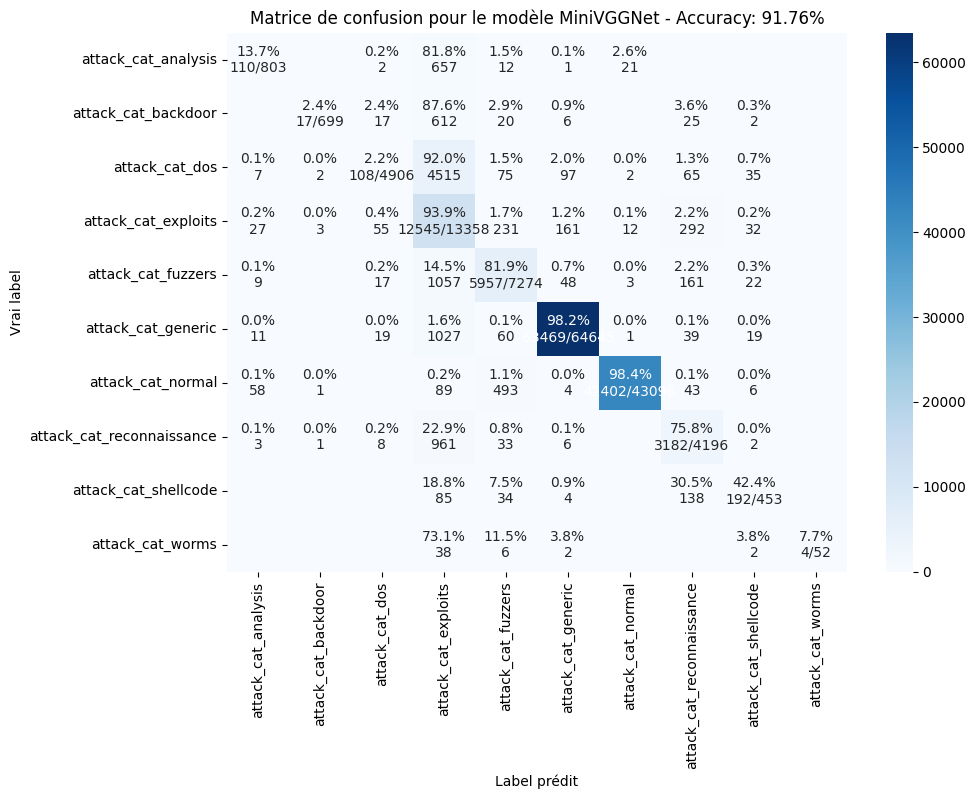

4359/4359 [==============================] - 8s 2ms/step


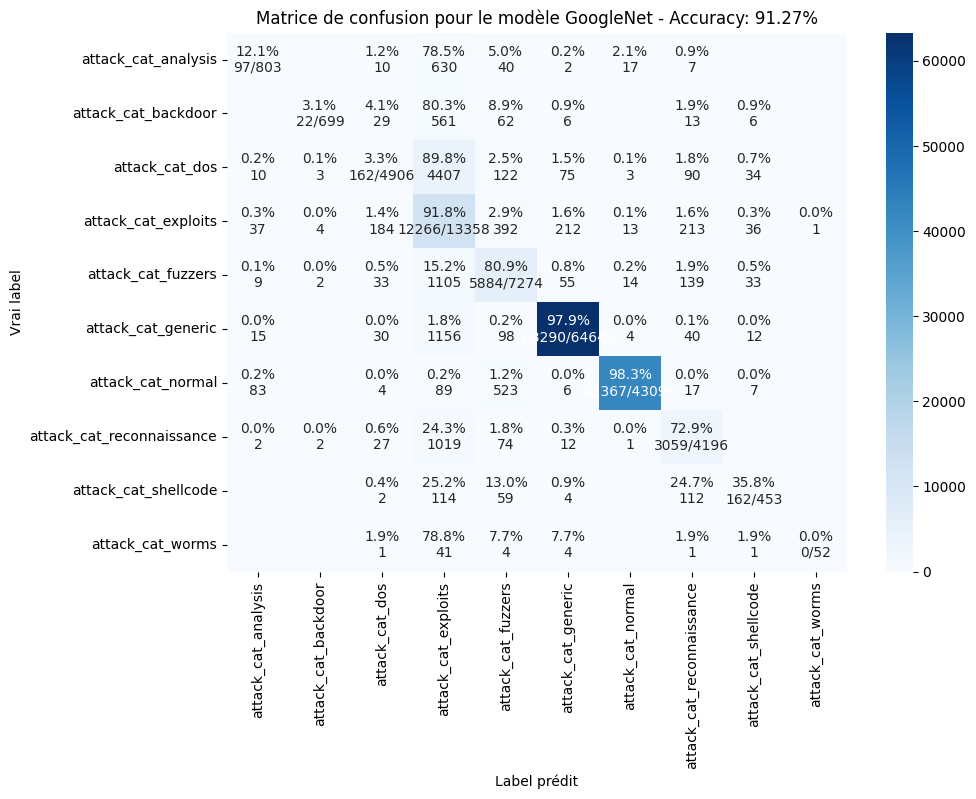

4359/4359 [==============================] - 9s 2ms/step


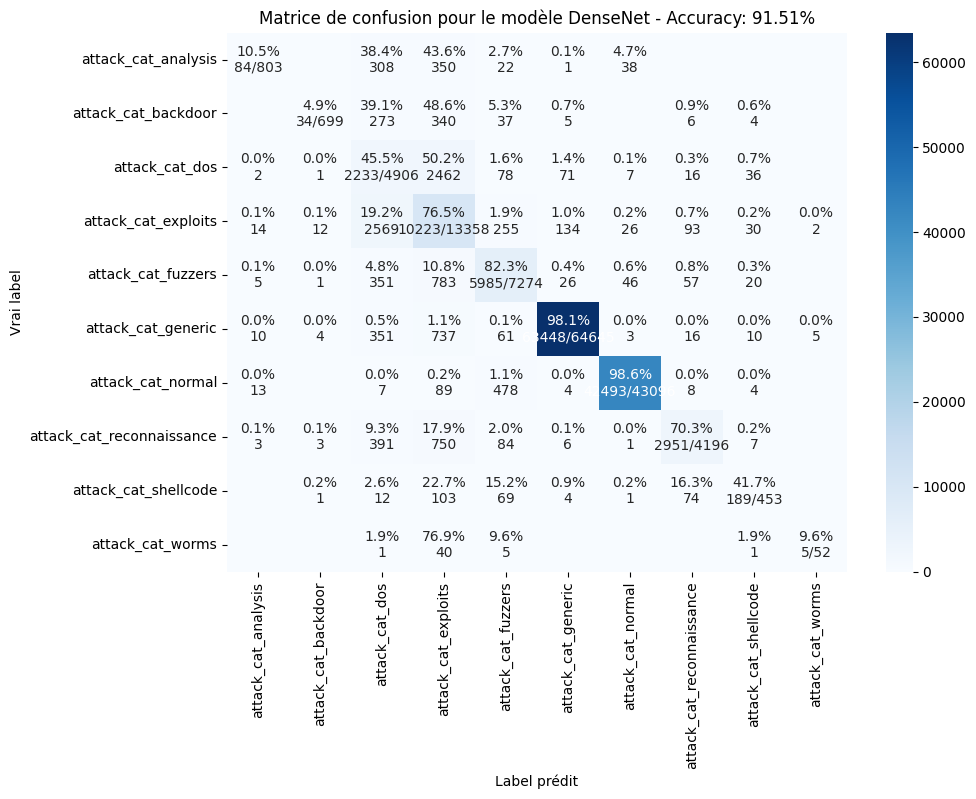

Architectures triées par accuracy :
MiniVGGNet: 91.76%
NormedConvNet: 91.74%
DenseNet: 91.51%
GoogleNet: 91.27%
ClassicConvNet: 91.26%


In [20]:
def plot_confusion_matrices(nets, names, x_test, y_test):
    accuracies = []  # Liste pour stocker les accuracies et les noms des architectures

    for net in range(nets):
        y_pred = model[net].predict(x_test)
        y_pred_classes = np.argmax(y_pred, axis=1)

        y_test_array = y_test.to_numpy()
        y_true_classes = np.argmax(y_test_array, axis=1)

        # Calcul de la matrice de confusion
        cm = confusion_matrix(y_true_classes, y_pred_classes)

        # Calcul de l'accuracy globale
        total_accuracy = np.trace(cm) / np.sum(cm) * 100
        accuracies.append((names[net], total_accuracy))

        # Calcul de l'accuracy pour chaque classe et création d'une nouvelle matrice pour l'affichage
        cm_sum = np.sum(cm, axis=1, keepdims=True)
        cm_perc = cm / cm_sum.astype(float) * 100
        annot = np.empty_like(cm).astype(str)
        nrows, ncols = cm.shape
        for i in range(nrows):
            for j in range(ncols):
                c = cm[i, j]
                p = cm_perc[i, j]
                if i == j:
                    s = cm_sum[i]
                    annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
                elif c == 0:
                    annot[i, j] = ''
                else:
                    annot[i, j] = '%.1f%%\n%d' % (p, c)

        # Tracer la matrice de confusion
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=annot, fmt='', cmap=plt.cm.Blues, xticklabels=y_cols, yticklabels=y_cols)
        plt.title(f"Matrice de confusion pour le modèle {names[net]} - Accuracy: {total_accuracy:.2f}%")
        plt.ylabel('Vrai label')
        plt.xlabel('Label prédit')
        plt.show()

    # Tri des architectures par accuracy et affichage
    accuracies.sort(key=lambda x: x[1], reverse=True)
    print("Architectures triées par accuracy :")
    for name, accuracy in accuracies:
        print(f"{name}: {accuracy:.2f}%")

# Appeler la fonction après l'entraînement des modèles
plot_confusion_matrices(nets, names, x_test, y_test)

DenseNet arrive à prédire avec 98% de précision les attaques générique et normal. De plus, les attaque exploits, fuzzers et reconnaissance ont également de très bon score. DenseNet est le modèle qui prédit le mieux les DoS.

In [ ]:
display(y_test)

,attack_cat_analysis,attack_cat_backdoor,attack_cat_dos,attack_cat_exploits,attack_cat_fuzzers,attack_cat_generic,attack_cat_normal,attack_cat_reconnaissance,attack_cat_shellcode,attack_cat_worms
298145,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
389429,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
25487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
97313,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
395441,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
327854,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
145148,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
207598,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
83948,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
nets = 5
model = [0] * nets
history = [0] * nets
names = ["1_block_DenseNet", "2_blocks_DenseNet", "3_blocks_DenseNet", "4_blocks_DenseNet", "5_blocks_DenseNet"]

epochs = 2
batch_size = 128

results = []  # Afin d'afficher les résultats de chaque modèle

for net in range(nets):
    input_img = Input(shape=(8, 8, 1))
    if net == 0: # 1_block_DenseNet
        # première couche de convolution
        x1 = Conv2D(32, (3, 3), padding='same', activation='relu')(input_img)
        x1 = BatchNormalization()(x1)
        concat1 = concatenate([input_img, x1])
        output = Flatten()(concat1)
        out = Dense(nb_classes, activation='softmax')(output)
    if net == 1: # 2_blocks_DenseNet
        # première couche de convolution
        x1 = Conv2D(32, (3, 3), padding='same', activation='relu')(input_img)
        x1 = BatchNormalization()(x1)
        concat1 = concatenate([input_img, x1])
        # deuxième couche de convolution
        x2 = Conv2D(32, (3, 3), padding='same', activation='relu')(concat1)
        x2 = BatchNormalization()(x2)
        concat2 = concatenate([input_img, x1, x2])
        output = Flatten()(concat2)
        out = Dense(nb_classes, activation='softmax')(output)
    if net == 2: # 3_blocks_DenseNet
        # première couche de convolution
        x1 = Conv2D(32, (3, 3), padding='same', activation='relu')(input_img)
        x1 = BatchNormalization()(x1)
        concat1 = concatenate([input_img, x1])
        # deuxième couche de convolution
        x2 = Conv2D(32, (3, 3), padding='same', activation='relu')(concat1)
        x2 = BatchNormalization()(x2)
        concat2 = concatenate([input_img, x1, x2])
        # troisième couche de convolution
        x3 = Conv2D(32, (3, 3), padding='same', activation='relu')(concat2)
        x3 = BatchNormalization()(x3)
        concat3 = concatenate([input_img, x1, x2, x3])
        output = Flatten()(concat3)
        out = Dense(nb_classes, activation='softmax')(output)
    if net == 3: # 4_blocks_DenseNet
        # première couche de convolution
        x1 = Conv2D(32, (3, 3), padding='same', activation='relu')(input_img)
        x1 = BatchNormalization()(x1)
        concat1 = concatenate([input_img, x1])
        # deuxième couche de convolution
        x2 = Conv2D(32, (3, 3), padding='same', activation='relu')(concat1)
        x2 = BatchNormalization()(x2)
        concat2 = concatenate([input_img, x1, x2])
        # troisième couche de convolution
        x3 = Conv2D(32, (3, 3), padding='same', activation='relu')(concat2)
        x3 = BatchNormalization()(x3)
        concat3 = concatenate([input_img, x1, x2, x3])
        # quatrième couche de convolution
        x4 = Conv2D(32, (3, 3), padding='same', activation='relu')(concat3)
        x4 = BatchNormalization()(x4)
        concat4 = concatenate([input_img, x1, x2, x3, x4])
        output = Flatten()(concat4)
        out = Dense(nb_classes, activation='softmax')(output)
    if net == 4: # 5_blocks_DenseNet
        # première couche de convolution
        x1 = Conv2D(32, (3, 3), padding='same', activation='relu')(input_img)
        x1 = BatchNormalization()(x1)
        concat1 = concatenate([input_img, x1])
        # deuxième couche de convolution
        x2 = Conv2D(32, (3, 3), padding='same', activation='relu')(concat1)
        x2 = BatchNormalization()(x2)
        concat2 = concatenate([input_img, x1, x2])
        # troisième couche de convolution
        x3 = Conv2D(32, (3, 3), padding='same', activation='relu')(concat2)
        x3 = BatchNormalization()(x3)
        concat3 = concatenate([input_img, x1, x2, x3])
        # quatrième couche de convolution
        x4 = Conv2D(32, (3, 3), padding='same', activation='relu')(concat3)
        x4 = BatchNormalization()(x4)
        concat4 = concatenate([input_img, x1, x2, x3, x4])
        # cinquième couche de convolution
        x5 = Conv2D(32, (3, 3), padding='same', activation='relu')(concat4)
        x5 = BatchNormalization()(x5)
        concat5 = concatenate([input_img, x1, x2, x3, x4, x5])
        output = Flatten()(concat5)
        out = Dense(nb_classes, activation='softmax')(output)

    # Début du chronomètre
    start_time = time.time()  # Début du chronomètre

    # Création du modèle
    model[net] = Model(inputs=input_img, outputs=out)
    model[net].summary()
    model[net].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    history[net] = model[net].fit(x_train, y_train, validation_data=(x_test, y_test), verbose=1, batch_size=batch_size,
                                  epochs=epochs)
    score = model[net].evaluate(x_test, y_test, verbose=0)

    # Fin du chronomètre
    end_time = time.time()  # Fin du chronomètre
    training_time = end_time - start_time
    model_params = model[net].count_params()

    # Stockage des résultats pour chaque modèle
    results.append({
        'Nom': names[net],
        'Accuracy': score[1],
        'Loss': score[0],
        'Nombre de paramètres': model_params,
        'Temps d\'entraînement': training_time
    })

    print("\nCNN: {}, Epochs={}, Batch_size={}, Test loss={}, Test accuracy={}\n".format(names[net], epochs, batch_size,
                                                                                         score[0], score[1]))

# Conversion de la liste en DataFrame
df_results = pd.DataFrame(results)

In [ ]:
plot_accuracies(nets,history,names,[0.895,0.92])
df_sorted = df_results.sort_values(by="Accuracy", ascending=False)
print(df_sorted)

Essayer d'ajouter des couches de transition sans pooling (car image très petite)

Normalement dans les DenseNet, il y a des couches de transitions entre les blocs de convolution. Ces couches de transitions permettent de réduire la dimension des images. Cependant, nos images sont déjà très petites (8x8). Donc ces couches de transitions seront testé mais sans pooling.

Couche de transition:
- Conv2D avec un kernel de 1x1 et fonction d'activation ReLU
- BatchNormalization
- Pooling

La version de couche de transition que l'on test est la suivante:
- Conv2D avec un kernel de 1x1 et fonction d'activation ReLU
- BatchNormalization

In [ ]:
def transition_layer(x, num_filters):
    x = Conv2D(num_filters, (1, 1), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    return x

In [ ]:
nets = 5
model = [0] * nets
history = [0] * nets
names = ["1_block_DenseNet", "2_blocks_DenseNet", "3_blocks_DenseNet", "4_blocks_DenseNet", "5_blocks_DenseNet"]

epochs = 2
batch_size = 128

results = []  # Afin d'afficher les résultats de chaque modèle

for net in range(nets):
    input_img = Input(shape=(8, 8, 1))
    if net == 0: # 1_block_DenseNet
        # première couche de convolution
        x1 = Conv2D(32, (3, 3), padding='same', activation='relu')(input_img)
        x1 = BatchNormalization()(x1)
        concat1 = concatenate([input_img, x1])
        concat1 = transition_layer(concat1, 32)  # couche de transition
        output = Flatten()(concat1)
        out = Dense(nb_classes, activation='softmax')(output)
    if net == 1: # 2_blocks_DenseNet
        # première couche de convolution
        x1 = Conv2D(32, (3, 3), padding='same', activation='relu')(input_img)
        x1 = BatchNormalization()(x1)
        concat1 = concatenate([input_img, x1])
        concat1 = transition_layer(concat1, 32)  # couche de transition
        # deuxième couche de convolution
        x2 = Conv2D(32, (3, 3), padding='same', activation='relu')(concat1)
        x2 = BatchNormalization()(x2)
        concat2 = concatenate([input_img, x1, x2])
        concat2 = transition_layer(concat2, 32)  # couche de transition
        output = Flatten()(concat2)
        out = Dense(nb_classes, activation='softmax')(output)
    if net == 2: # 3_blocks_DenseNet
        # première couche de convolution
        x1 = Conv2D(32, (3, 3), padding='same', activation='relu')(input_img)
        x1 = BatchNormalization()(x1)
        concat1 = concatenate([input_img, x1])
        concat1 = transition_layer(concat1, 32)  # couche de transition
        # deuxième couche de convolution
        x2 = Conv2D(32, (3, 3), padding='same', activation='relu')(concat1)
        x2 = BatchNormalization()(x2)
        concat2 = concatenate([input_img, x1, x2])
        concat2 = transition_layer(concat2, 32)  # couche de transition
        # troisième couche de convolution
        x3 = Conv2D(32, (3, 3), padding='same', activation='relu')(concat2)
        x3 = BatchNormalization()(x3)
        concat3 = concatenate([input_img, x1, x2, x3])
        concat3 = transition_layer(concat3, 32)  # couche de transition
        output = Flatten()(concat3)
        out = Dense(nb_classes, activation='softmax')(output)
    if net == 3: # 4_blocks_DenseNet
        # première couche de convolution
        x1 = Conv2D(32, (3, 3), padding='same', activation='relu')(input_img)
        x1 = BatchNormalization()(x1)
        concat1 = concatenate([input_img, x1])
        concat1 = transition_layer(concat1, 32)  # couche de transition
        # deuxième couche de convolution
        x2 = Conv2D(32, (3, 3), padding='same', activation='relu')(concat1)
        x2 = BatchNormalization()(x2)
        concat2 = concatenate([input_img, x1, x2])
        concat2 = transition_layer(concat2, 32)  # couche de transition
        # troisième couche de convolution
        x3 = Conv2D(32, (3, 3), padding='same', activation='relu')(concat2)
        x3 = BatchNormalization()(x3)
        concat3 = concatenate([input_img, x1, x2, x3])
        concat3 = transition_layer(concat3, 32)  # couche de transition
        # quatrième couche de convolution
        x4 = Conv2D(32, (3, 3), padding='same', activation='relu')(concat3)
        x4 = BatchNormalization()(x4)
        concat4 = concatenate([input_img, x1, x2, x3, x4])
        concat4 = transition_layer(concat4, 32)  # couche de transition
        output = Flatten()(concat4)
        out = Dense(nb_classes, activation='softmax')(output)
    if net == 4: # 5_blocks_DenseNet
        # première couche de convolution
        x1 = Conv2D(32, (3, 3), padding='same', activation='relu')(input_img)
        x1 = BatchNormalization()(x1)
        concat1 = concatenate([input_img, x1])
        concat1 = transition_layer(concat1, 32)  # couche de transition
        # deuxième couche de convolution
        x2 = Conv2D(32, (3, 3), padding='same', activation='relu')(concat1)
        x2 = BatchNormalization()(x2)
        concat2 = concatenate([input_img, x1, x2])
        concat2 = transition_layer(concat2, 32)  # couche de transition
        # troisième couche de convolution
        x3 = Conv2D(32, (3, 3), padding='same', activation='relu')(concat2)
        x3 = BatchNormalization()(x3)
        concat3 = concatenate([input_img, x1, x2, x3])
        concat3 = transition_layer(concat3, 32)  # couche de transition
        # quatrième couche de convolution
        x4 = Conv2D(32, (3, 3), padding='same', activation='relu')(concat3)
        x4 = BatchNormalization()(x4)
        concat4 = concatenate([input_img, x1, x2, x3, x4])
        concat4 = transition_layer(concat4, 32)  # couche de transition
        # cinquième couche de convolution
        x5 = Conv2D(32, (3, 3), padding='same', activation='relu')(concat4)
        x5 = BatchNormalization()(x5)
        concat5 = concatenate([input_img, x1, x2, x3, x4, x5])
        concat5 = transition_layer(concat5, 32)  # couche de transition
        output = Flatten()(concat5)
        out = Dense(nb_classes, activation='softmax')(output)

    # Début du chronomètre
    start_time = time.time()  # Début du chronomètre

    # Création du modèle
    model[net] = Model(inputs=input_img, outputs=out)
    model[net].summary()
    model[net].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    history[net] = model[net].fit(x_train, y_train, validation_data=(x_test, y_test), verbose=1, batch_size=batch_size,
                                  epochs=epochs)
    score = model[net].evaluate(x_test, y_test, verbose=0)

    # Fin du chronomètre
    end_time = time.time()  # Fin du chronomètre
    training_time = end_time - start_time
    model_params = model[net].count_params()

    # Stockage des résultats pour chaque modèle
    results.append({
        'Nom': names[net],
        'Accuracy': score[1],
        'Loss': score[0],
        'Nombre de paramètres': model_params,
        'Temps d\'entraînement': training_time
    })

    print("\nCNN: {}, Epochs={}, Batch_size={}, Test loss={}, Test accuracy={}\n".format(names[net], epochs, batch_size,
                                                                                         score[0], score[1]))

# Conversion de la liste en DataFrame
df_results = pd.DataFrame(results)